In [9]:
from pathlib import Path
import re

import numpy as np 
from scipy import stats
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm.auto as tqdm

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [11]:
df = pd.read_csv('Housing.csv')

In [12]:
# Initially declaring the target feature, as it will be utilised further down the line.
target = 'MEDV'

In [13]:
# There are multiple features that have a high distriubtion from the median, signaling a high right/left skew.
# This will be noted as unskew strategies will be applied later on.
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,509.000000,509.000000,506.000000,509.000000,507.000000,509.000000,508.000000,509.000000,508.000000,509.000000,509.000000,509.000000,508.000000,509.000000
mean,3.707516,11.296660,11.198281,0.068762,0.555216,6.279845,68.579134,3.787705,9.610236,409.216110,18.463851,356.664892,12.705276,22.501572
std,8.732089,23.269781,6.856713,0.253298,0.115633,0.703449,28.114744,2.101852,8.735069,168.814161,2.161553,91.562469,7.131979,9.183497
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082210,0.000000,5.190000,0.000000,0.449000,5.880000,45.075000,2.100700,4.000000,279.000000,17.400000,375.330000,7.092500,17.000000
50%,0.261690,0.000000,9.690000,0.000000,0.538000,6.202000,77.150000,3.182700,5.000000,330.000000,19.100000,391.450000,11.430000,21.200000
75%,3.693110,12.500000,18.100000,0.000000,0.624000,6.619000,94.100000,5.118000,24.000000,666.000000,20.200000,396.240000,16.992500,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [22]:
# CHAS Feature is binary, however, it is not indicated as such in the original dataset
df.dtypes

CRIM       float64
ZN         float64
INDUS      float64
CHAS         int64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD        float64
TAX          int64
PTRATIO    float64
B          float64
LSTAT      float64
MEDV       float64
dtype: object

In [14]:
# There are multiple feature that are missing data, as, fortunately, 
# all the features are numerical a median fill approach can be utilized.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509 entries, 0 to 508
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     509 non-null    float64
 1   ZN       509 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     509 non-null    int64  
 4   NOX      507 non-null    float64
 5   RM       509 non-null    float64
 6   AGE      508 non-null    float64
 7   DIS      509 non-null    float64
 8   RAD      508 non-null    float64
 9   TAX      509 non-null    int64  
 10  PTRATIO  509 non-null    float64
 11  B        509 non-null    float64
 12  LSTAT    508 non-null    float64
 13  MEDV     509 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.8 KB


In [15]:
df.nunique()

CRIM       503
ZN          26
INDUS       76
CHAS         2
NOX         81
RM         446
AGE        354
DIS        411
RAD          9
TAX         66
PTRATIO     46
B          356
LSTAT      453
MEDV       228
dtype: int64

In [16]:
def plot_hist(df):
    # Selecting numerical features, this is not required as all features
    # are numerical
    cols = (
        df
        .select_dtypes(include=[int, float])
        .columns
    )

    ncols = 2
    # Determining how many rows will be required based on the number of features
    # that are available; this process is agile and won't require modifications
    # if new features will be added
    nrows = np.ceil(len(cols) / ncols).astype(int)
    # The more features there are available the larger the figure will become
    vertical_figsize = 2 * nrows

    axs = plt.subplots(nrows, ncols, figsize=[10, vertical_figsize])[1].flatten()

    for col, ax in zip(cols, axs):
        df[col].plot.hist(title=col, ax=ax)
    plt.tight_layout()
    plt.show()

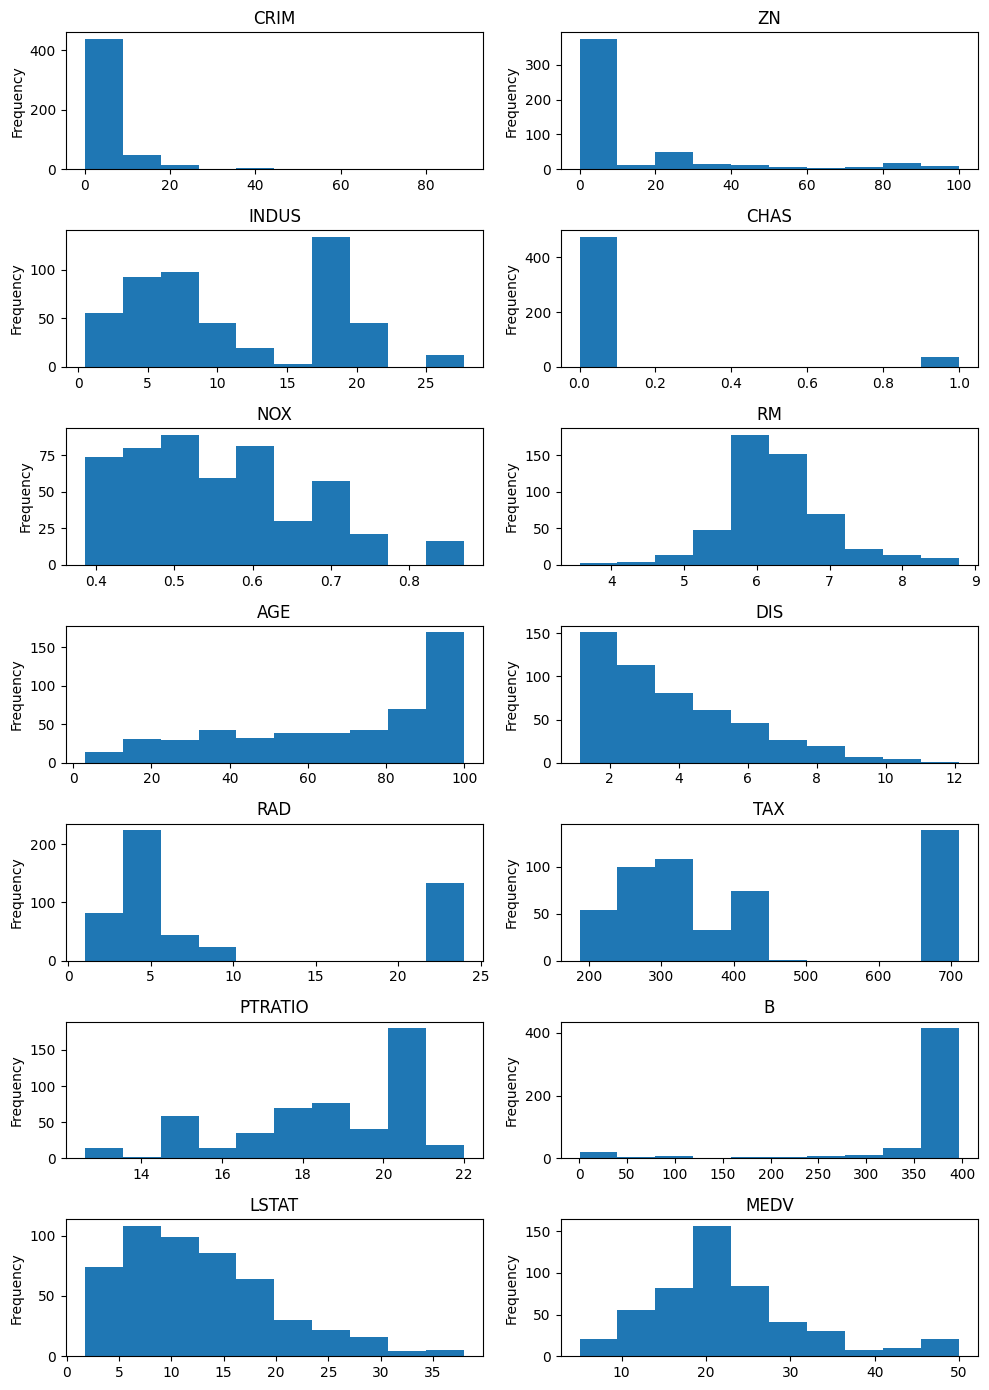

In [17]:
plot_hist(df)

In [18]:
#Processing
# As previously metnioned, NaN values will be substituted with median
df = df.fillna(df.median(axis=0))

In [19]:
df['CHAS'] = df['CHAS'].astype(bool)

In [20]:
#Feature Construction
df['CRIM_ZN'] = df['CRIM'] * df['ZN']
df['INDUS_CHAS'] = df['INDUS'] * df['CHAS']
df['NOX_DIS'] = df['NOX'] * df['DIS']
df['RM_AGE'] = df['RM'] * df['AGE']
df['RAD_TAX'] = df['RAD'] * df['TAX']
df['PTRATIO_B'] = df['PTRATIO'] * df['B']

In [21]:
#Unskewing data
skew_res = df.select_dtypes([int, float]).skew().abs().sort_values(ascending=False)
skew_cols = skew_res.loc[lambda x: (x>=1) & (x.index!=target)].index

print(skew_res)
print('-'*50)
print('Cols that are skewed:')
print(', '.join(skew_cols))

CRIM          5.054175
INDUS_CHAS    4.308544
CRIM_ZN       3.878058
B             2.901548
ZN            2.235507
PTRATIO_B     2.074049
MEDV          1.113497
RAD_TAX       1.052768
DIS           1.020237
RAD           0.991625
NOX_DIS       0.950406
LSTAT         0.902423
PTRATIO       0.810759
NOX           0.725956
TAX           0.659313
AGE           0.600076
RM_AGE        0.443375
RM            0.409825
INDUS         0.282337
dtype: float64
--------------------------------------------------
Cols that are skewed:
CRIM, INDUS_CHAS, CRIM_ZN, B, ZN, PTRATIO_B, RAD_TAX, DIS


In [22]:
def best_transformation(data) -> tuple:
    functions = [np.log1p, np.sqrt, stats.yeojohnson]
    results = []
    
    for func in functions:
        transformed_data = func(data)
        if type(transformed_data) == tuple:
            vals, _ = transformed_data
            results.append(vals)
        else:
            results.append(transformed_data)
            
    abs_skew_results = [np.abs(stats.skew(val)) for val in results]
    lowest_skew_index = abs_skew_results.index(min(abs_skew_results))
    return functions[lowest_skew_index], results[lowest_skew_index]


----------------------------------------------------------------------------------------------------
CRIM skew is: 5.039268385290411
Best function <function yeojohnson at 0x000002C65BD19620> and the skew results: 0.5919198316128842


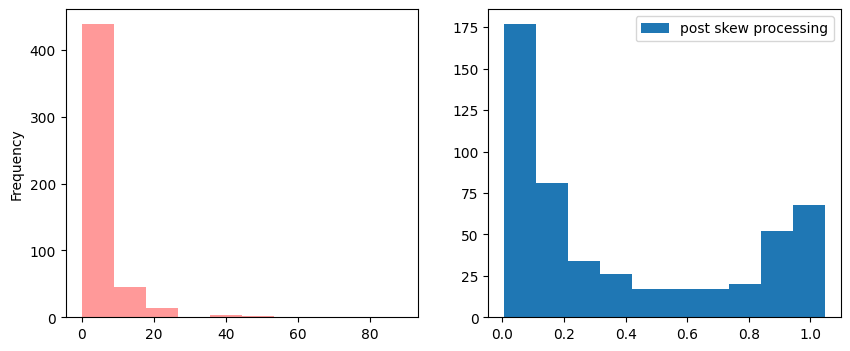

----------------------------------------------------------------------------------------------------
INDUS_CHAS skew is: 4.2958364268220945
Best function <function yeojohnson at 0x000002C65BD19620> and the skew results: 3.408344889722243


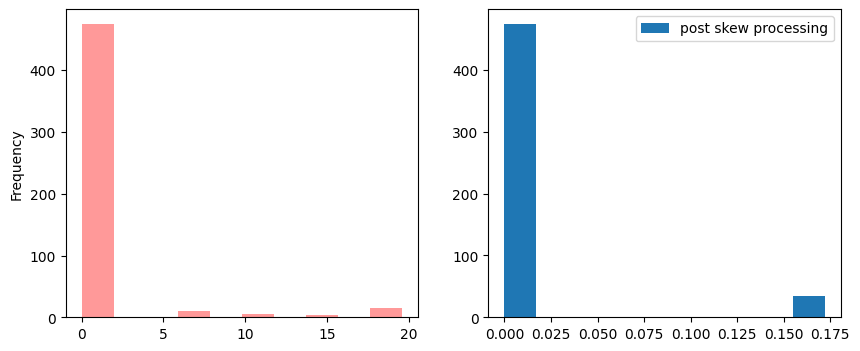

Transformation was not successful for INDUS_CHAS, returning original data
----------------------------------------------------------------------------------------------------
CRIM_ZN skew is: 3.8666200276645553
Best function <function yeojohnson at 0x000002C65BD19620> and the skew results: 1.1179400497645273


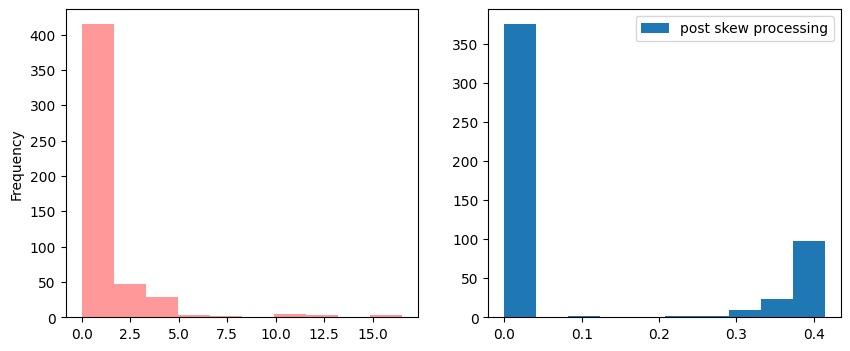

Transformation was not successful for CRIM_ZN, returning original data
----------------------------------------------------------------------------------------------------
B skew is: -2.8929901521077115
Best function <function yeojohnson at 0x000002C65BD19620> and the skew results: -1.9129389424519136


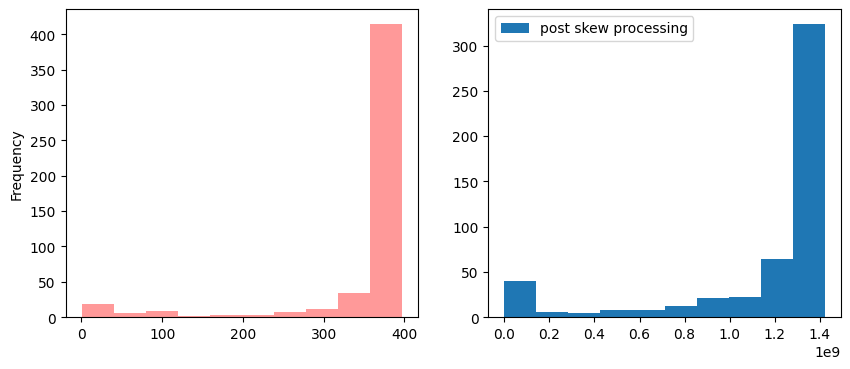

Transformation was not successful for B, returning original data
----------------------------------------------------------------------------------------------------
ZN skew is: 2.2289141017520993
Best function <function yeojohnson at 0x000002C65BD19620> and the skew results: 1.077526722724403


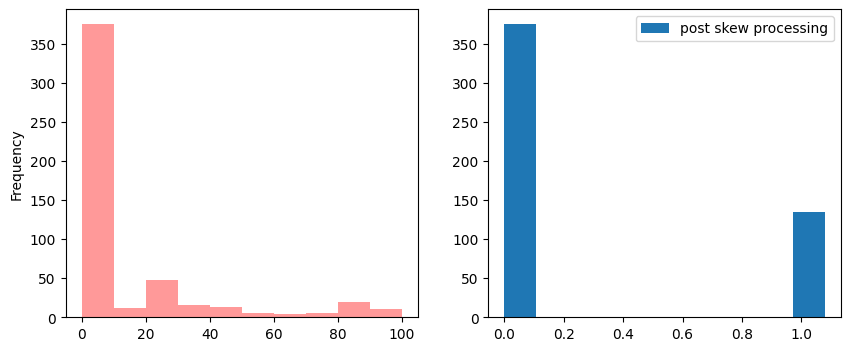

Transformation was not successful for ZN, returning original data
----------------------------------------------------------------------------------------------------
PTRATIO_B skew is: -2.067932021002207
Best function <function yeojohnson at 0x000002C65BD19620> and the skew results: -0.8972823754815756


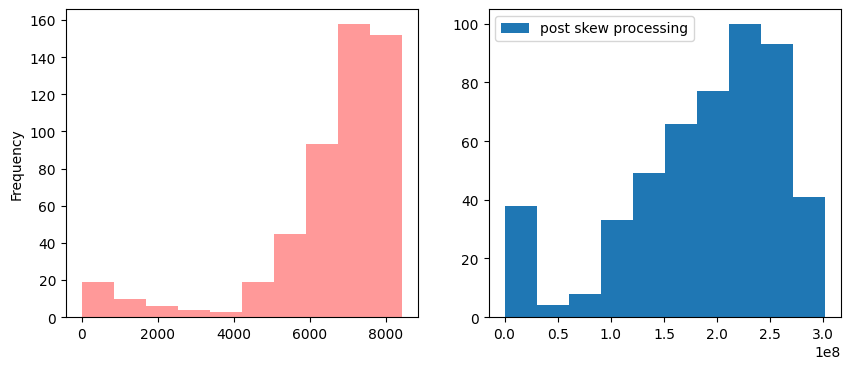

----------------------------------------------------------------------------------------------------
RAD_TAX skew is: 1.0496626140364416
Best function <function yeojohnson at 0x000002C65BD19620> and the skew results: 0.06768723252384833


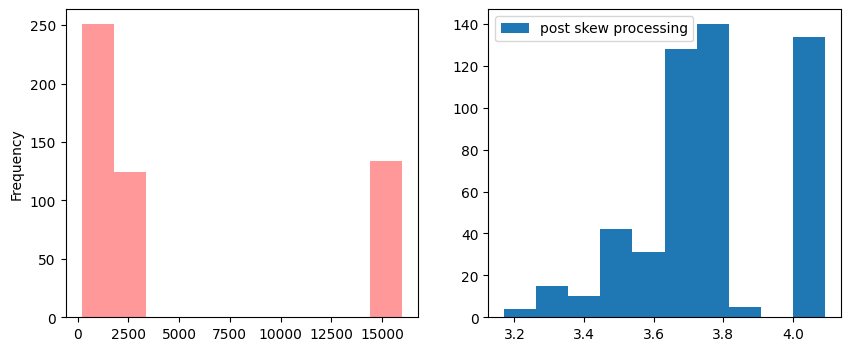

----------------------------------------------------------------------------------------------------
DIS skew is: 1.0172283893817673
Best function <function yeojohnson at 0x000002C65BD19620> and the skew results: 0.06811070959321701


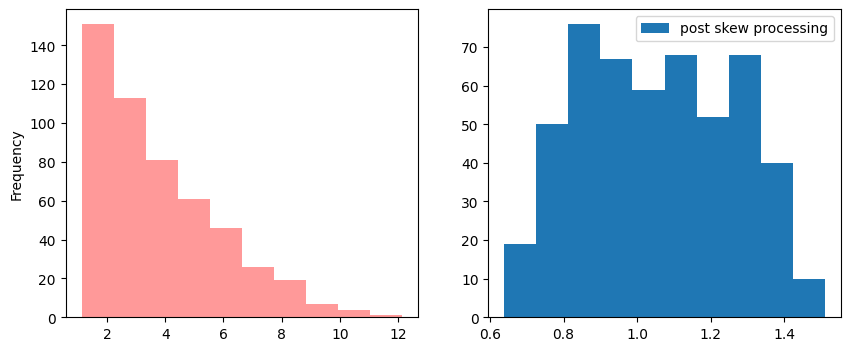

In [23]:
def unskew(col):
    global best_transformation
    print('-'*100)
    col_skew = stats.skew(col)
    col_name = col.name
    print('{} skew is: {}'.format(col_name, col_skew))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[10, 4])
    col.plot.hist(color='red', alpha=.4, label='pre-skew', ax=ax1)

    if np.abs(col_skew) >= 1.:
        result_skew, data = best_transformation(col)
        new_col_skew = stats.skew(data)
        print(f'Best function {result_skew} and the skew results: {new_col_skew}')
        ax2.hist(data, label='post skew processing')
        plt.legend()
        plt.show()
        
        if np.abs(new_col_skew) >= 1.:
            print(f'Transformation was not successful for {col_name}, returning original data')
            return col 
        
        return data 
    
    plt.show()
    
df[skew_cols] = df[skew_cols].apply(unskew, axis=0);

In [24]:
#Feature Selection
#Selecting highest correlated data with the target

corr_ranking = (
    df
    .drop(target, axis=1)
    .corrwith(df[target])
    .abs()
    .sort_values(ascending=False)
)

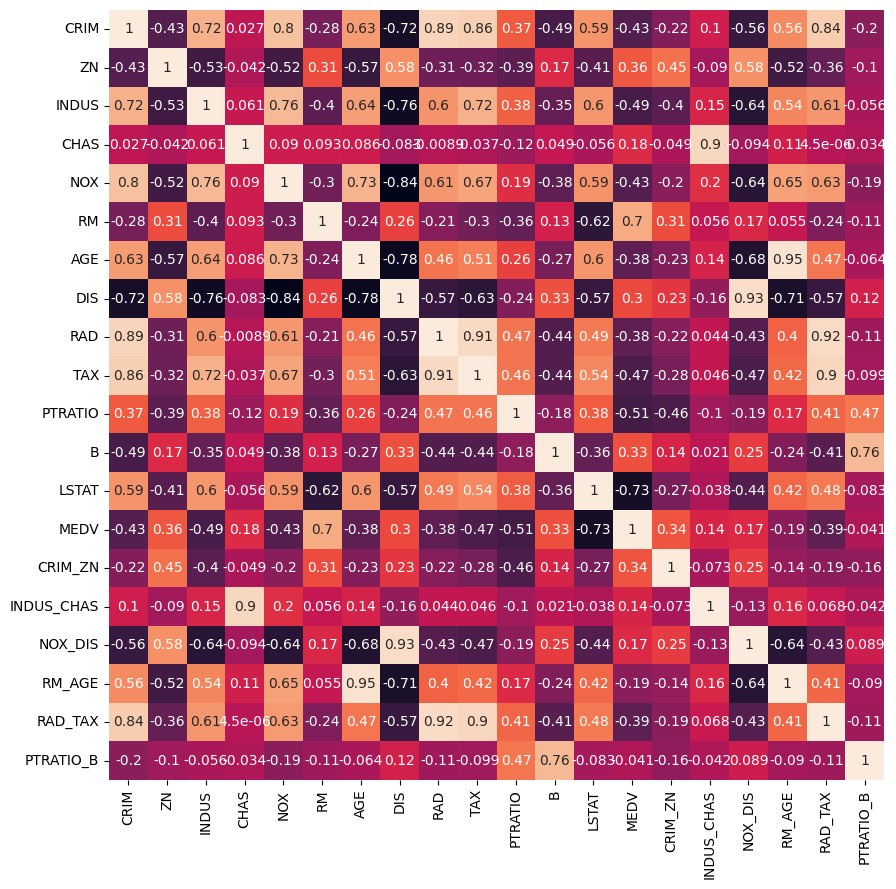

In [25]:
_, ax = plt.subplots(figsize=[10, 10])
sns.heatmap(df.corr(), annot=True, cmap="rocket", cbar=False, ax=ax);

In [26]:
# Taking all the values above 0.3

threshold = .3
chosen_cols = corr_ranking[corr_ranking>=threshold]
print(chosen_cols)
chosen_cols = chosen_cols.index.to_list()

LSTAT      0.734829
RM         0.695750
PTRATIO    0.508786
INDUS      0.486802
TAX        0.469888
CRIM       0.431056
NOX        0.428495
RAD_TAX    0.387156
RAD        0.383350
AGE        0.377958
ZN         0.361314
CRIM_ZN    0.344115
B          0.332876
dtype: float64


In [27]:
#Data Preparation
#Train test split

X = df[chosen_cols]
y = df[target]

In [28]:
X.shape, y.shape

((509, 13), (509,))

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [30]:
#Scaling
X_train.dtypes

LSTAT      float64
RM         float64
PTRATIO    float64
INDUS      float64
TAX          int64
CRIM       float64
NOX        float64
RAD_TAX    float64
RAD        float64
AGE        float64
ZN         float64
CRIM_ZN    float64
B          float64
dtype: object

In [31]:
# Since CHAS did not pass correlation filtration there is no need to remove it
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

cols = X_train.select_dtypes([float, int]).columns.to_list()

X_train[cols] = scaler.fit_transform(X_train)
X_test[cols] = scaler.transform(X_test)

In [32]:
#Model Construction
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [33]:
n_features = X_train.shape[1]

In [34]:
random_forest_params = {
    'n_estimators': np.sort(np.random.default_rng().choice(500, size=10, replace=False)),
    'max_features': np.sort(np.random.default_rng().choice(n_features, size=5, replace=False)),
    'max_depth': [1, 5, 10],
}

In [35]:
xgb_params = {
    'objective': ['reg:squarederror'],
    'max_depth': [2, 5,],
    'min_child_weight': np.arange(1, 5, 2),
    'n_estimators': np.sort(np.random.default_rng().choice(500, size=3, replace=False)),
    'learning_rate': [1e-1, 1e-2,],
    'gamma': np.sort(np.random.default_rng().choice(20, size=3, replace=False)),
    'reg_lambda': [0, 1.0, 10.0],
    'scale_pos_weight': [1, 3, 5],
    'n_jobs': [-1],
}

In [36]:
best_mode_params = {
    LinearRegression(): {'fit_intercept': True},
    RandomForestRegressor(): {'max_depth': 10, 'max_features': 9, 'n_estimators': 378},
    XGBRegressor(): {'gamma': 18, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 461, 'n_jobs': -1, 'objective': 'reg:squarederror', 'reg_lambda': 0, 'scale_pos_weight': 1},
}

In [37]:
from sklearn.metrics import mean_squared_error, r2_score
b_models = []
model_results = []

for model in best_mode_params.keys():
    params = best_mode_params[model]
    model.set_params(**params)
    model.fit(X_train, y_train)    
    b_models.append(model)
    
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    model_name = re.search(r'\w+', str(model))[0]
    results = pd.Series({'MSE': mse, 'RMSE': rmse, 'R2': r2}, name=model_name)
    model_results.append(results)

In [38]:
#Evaluation
pd.concat(model_results, axis=1)

,LinearRegression,RandomForestRegressor,XGBRegressor
MSE,29.354735,12.806661,11.694918
RMSE,5.418001,3.578639,3.419783
R2,0.626707,0.837143,0.851280


In [39]:
#As visible from above, XGBoost outperformed RandomForest.

feature_imp = []
for model in b_models:
    try:
        model_name = re.search(r'\w+', str(model))[0]
        feature_imp.append(
            pd.Series(
                {
                    col: importance 
                    for col, importance in zip(cols, model.feature_importances_)
                },
                name = model_name
            )
        )
    except AttributeError:
        pass
    
pd.concat(feature_imp, axis=1).sort_values(by='XGBRegressor', ascending=False)


,RandomForestRegressor,XGBRegressor
LSTAT,0.312625,0.352651
RM,0.445479,0.349244
AGE,0.027385,0.073239
CRIM,0.074713,0.062813
NOX,0.046944,0.054050
PTRATIO,0.017445,0.030175
TAX,0.016757,0.022917
B,0.013510,0.019786
RAD,0.006365,0.016712
RAD_TAX,0.010878,0.010808


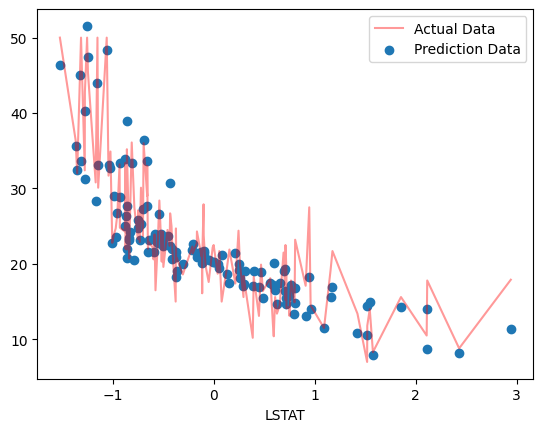

In [40]:
#Actual data v/s prediction data
xgb_model = b_models[2]
col = 'LSTAT'
y_pred = xgb_model.predict(X_test.sort_values(by=col))

(
    pd.concat([X_test[col], y_test], axis=1)
    .sort_values(by=col)
    .plot(x=col, y='MEDV', color='red', alpha=.4, label='Actual Data'),
)

plt.scatter(X_test[col].sort_values(), y_pred, label='Prediction Data')
plt.legend()
plt.show()

In [41]:
x = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.2)

In [42]:
#Evaluation Pipeline¶
#Evaluation pipeline to automate the process of training and evaluation, instead of training and evaluating for every model

class Evaluation:
    def __init__(self, train, test):
        self.train = train
        self.test = test
        
    def evaluate(self, model, name):
        x, y = self.train
        y_pred = model.predict(x)
        mae = mean_absolute_error(y_pred, y)
        mse = mean_squared_error(y_pred, y)
        r2 = r2_score(y_pred, y)
        print(name, "\n", "-"*20)
        print("MAE: {}\nMSE: {}\nr2: {}".format(mae, mse, r2))
        
    def training(self, model, name):
        x, y = self.train
        model.fit(x, y)
        self.evaluate(model, name)
        return model

In [43]:
#Defining models, tuning their hyperparameters¶
lnr = LinearRegression()
rfr = RandomForestRegressor(n_estimators=150, max_depth=115, criterion='friedman_mse',
                           max_features='log2')
dtr = DecisionTreeRegressor(max_depth=110,criterion='friedman_mse')
svr = SVR(C=0.7)
abr = AdaBoostRegressor(n_estimators=50, learning_rate=0.5)
xgb = XGBRegressor(n_estimators=1000, max_depth=11, eta=0.31)

models = [lnr, rfr, dtr, svr, abr, xgb]
names = ['Linear Regression', 'Random Forest Regressor',
        'Decision Tree Regressor', 'SVR',
        'Ada Boost Regressor', 'XGBRegressor']

assesment = Evaluation((X_train, y_train), (X_test, y_test))

In [44]:
assesment_selected = Evaluation((X_train, y_train), (X_test, y_test))
selected_trained = []
for i, j in zip(models, names):
    selected_trained += [assesment_selected.training(i, j)]

Linear Regression 
 --------------------
MAE: 10053237.03864676
MSE: 247995775718277.7
r2: 0.9568672358818947
Random Forest Regressor 
 --------------------
MAE: 5017453.557676362
MSE: 54807116120527.305
r2: 0.9894648214939504
Decision Tree Regressor 
 --------------------
MAE: 1.4351978348865555e-08
MSE: 2.361201597335468e-15
r2: 1.0
SVR 
 --------------------
MAE: 60333104.18086065
MSE: 6251950101467211.0
r2: -600913624008486.9
Ada Boost Regressor 
 --------------------
MAE: 8256145.396682847
MSE: 106877668980479.72
r2: 0.9802432924796054
XGBRegressor 
 --------------------
MAE: 16.02089815948947
MSE: 425.4174365754853
r2: 0.9999999999999291


<Axes: >

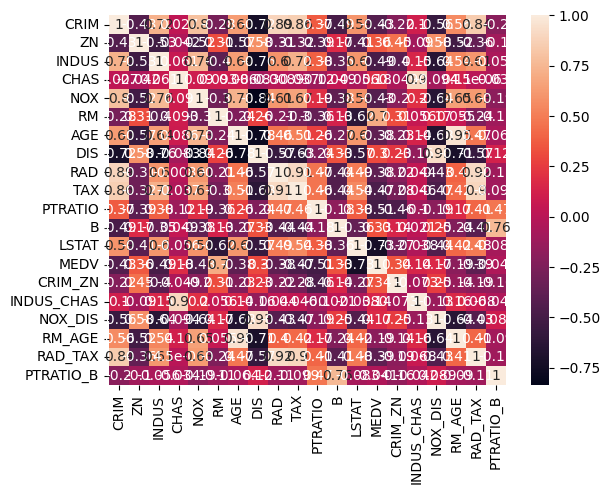

In [45]:
#Feature Selection
corr_matrix = df.corr(method='pearson')
sns.heatmap(corr_matrix, annot=True)

In [46]:
#Threshold
selected = []
for i in corr_matrix.index[:-1]:
    if corr_matrix.loc[i, "MEDV"] > 0.4 or corr_matrix.loc[i, "MEDV"] < -0.4:
        selected += [i]

In [50]:
x_s = df.loc[:, selected].values
y_s = df.loc[:, 'MEDV'].values
X_train, X_test, ys_train, ys_test = train_test_split(x_s, y_s, random_state=42, test_size=0.2)

In [51]:
assesment_selected = Evaluation((X_train, y_train), (X_test, ys_test))
selected_trained = []
for i, j in zip(models, names):
    selected_trained += [assesment_selected.training(i, j)]

Linear Regression 
 --------------------
MAE: 37305935.157074265
MSE: 3487582836465609.5
r2: -0.38947275343410137
Random Forest Regressor 
 --------------------
MAE: 11810187.22356927
MSE: 410421938273300.3
r2: 0.9004878959624572
Decision Tree Regressor 
 --------------------
MAE: 2.1967313799284015e-10
MSE: 6.546769678379302e-18
r2: 1.0
SVR 
 --------------------
MAE: 60333105.191614464
MSE: 6251950624158317.0
r2: -308918881915497.56
Ada Boost Regressor 
 --------------------
MAE: 38966553.78874022
MSE: 3000940543882617.5
r2: -1.1238988172481412
XGBRegressor 
 --------------------
MAE: 16.570811911793477
MSE: 493.3798792533565
r2: 0.9999999999999177
